In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [2]:
import logging
import os
import pickle
from typing import List, Tuple, Type

import numpy as np
import geopandas as gpd
import rasterio
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loading.rasterio_utils import get_thumbnail
from src.unet.satellite_image import SatelliteImage
from src.unet.downsampling import downsample_image, generate_thumbnail_parallel, generate_downsamples_parallel
from rasterio.plot import reshape_as_raster, reshape_as_image
import xarray as xr

from src.constants import SRC_PATH, GWS_DATA_DIR, WGS84, UTM35N, SENTINEL_DIR
SENTINEL_POLESIA_DIR = SENTINEL_DIR / "Polesia_10m"
SENTINEL_CHERNOBYL_DIR = SENTINEL_DIR / "Chernobyl_10m"

## 1. Resampling to get image pyramid and thumbnail

### 1.1 Create thumbnails and downsamples

In [3]:
chernobyl_files = list(SENTINEL_CHERNOBYL_DIR.glob("*[0-9].tif"))
polesia_files = list(SENTINEL_POLESIA_DIR.glob("*[0-9].tif"))

In [4]:
%%time
generate_thumbnail_parallel(chernobyl_files, n_workers=22)
generate_thumbnail_parallel(polesia_files, n_workers=22)

100%|██████████| 100/100 [00:00<00:00, 3628.70it/s]
0it [00:00, ?it/s]

CPU times: user 34.8 ms, sys: 274 ms, total: 309 ms
Wall time: 370 ms


In [5]:
%%time
generate_downsamples_parallel(chernobyl_files, downsample_factor=2, n_workers=22)
generate_downsamples_parallel(polesia_files, downsample_factor=2, n_workers=22)

100%|██████████| 100/100 [00:00<00:00, 8312.63it/s]
0it [00:00, ?it/s]

CPU times: user 40.4 ms, sys: 291 ms, total: 331 ms
Wall time: 362 ms


In [6]:
%%time
generate_downsamples_parallel(chernobyl_files, downsample_factor=4, n_workers=22)
generate_downsamples_parallel(polesia_files, downsample_factor=4, n_workers=22)

100%|██████████| 100/100 [00:00<00:00, 4343.82it/s]
0it [00:00, ?it/s]

CPU times: user 43.1 ms, sys: 240 ms, total: 283 ms
Wall time: 319 ms


In [7]:
%%time
generate_downsamples_parallel(chernobyl_files, downsample_factor=8, n_workers=22)
generate_downsamples_parallel(polesia_files, downsample_factor=8, n_workers=22)

100%|██████████| 100/100 [00:00<00:00, 8774.33it/s]
0it [00:00, ?it/s]

CPU times: user 45.5 ms, sys: 234 ms, total: 279 ms
Wall time: 305 ms


## 2. Getting a sample tile

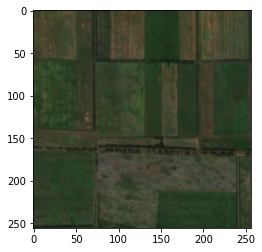

In [8]:
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_image
from src.unet.satellite_image import SatelliteImage


example_folder = SENTINEL_DIR / "Example"
image_paths = list(example_folder.glob("*[0-9].tif"))

img = SatelliteImage(image_paths)

# sample tile
rgb_bands = [2,1,0]
sample_tile = reshape_as_image(img[rgb_bands, 0:256, 0:256] / 3000)
sample_tile.compute()

plt.imshow(sample_tile)

## 3. Combining satellite images from different shards

In [421]:
from src.unet.satellite_image import SatelliteImage

example_folder = SENTINEL_DIR / "Example"

thumbnail_paths = list(example_folder.glob("*_thumbnail.tif"))
image_paths = list(example_folder.glob("*[0-9].tif"))

thumbnail_img = SatelliteImage(thumbnail_paths)
img = SatelliteImage(image_paths)
img.combined_image

,Array,Chunk
Bytes,9.55 GB,524.29 kB
Shape,"(10, 10047, 11879)","(1, 256, 256)"
Count,56404 Tasks,18800 Chunks
Type,float64,numpy.ndarray


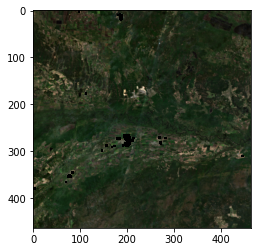

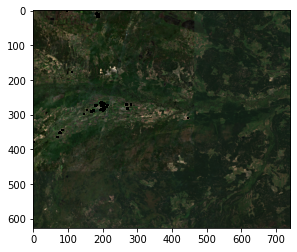

In [419]:
## Individual thumbnail
plt.imshow(reshape_as_image(thumbnail_img.shard_handles[0].data.compute()))
plt.show()

## Combined thumbnails
plt.imshow(reshape_as_image(thumbnail_img.combined_image.compute()))

## 4. Create labels from polesia vector data

In [407]:
import geopandas as gpd
polesia_path = GWS_DATA_DIR / "chernobyl_habitat_data" / "Biotope_EUNIS_ver1_1.shp"
polesia_vector = gpd.read_file(polesia_path)

superclasses = [
    8,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    2,
    3,
    4,
    5,
    5,
    6,
    6,
    6,
    7,
    7,
    7,
    7,
    9,
    10,
    11,
    11,
    12,
    12,
    13,
    13,
    13,
    13,
    14,
    14,
    15,
    15,
    19,
    16,
    17,
    18,
    18,
    18,
    18,
    18
    ]

eunis_classes = [
    1,
    21,
    22,
    23,
    24,
    29,
    30,
    31,
    33,
    2,
    3,
    4,
    38,
    43,
    35,
    36,
    37,
    25,
    26,
    27,
    28,
    5,
    6,
    7,
    8,
    9,
    11,
    16,
    17,
    18,
    32,
    19,
    34,
    39,
    40,
    10,
    41,
    42,
    12,
    13,
    14,
    15,
    20]

EUNIS_TO_SUPERCLASS = {eunis : sclass for eunis, sclass in zip(eunis_classes, superclasses)}

map_eunis_to_superclass = lambda eunis: EUNIS_TO_SUPERCLASS[eunis]

### 4.1 Inspect labels

<AxesSubplot:>

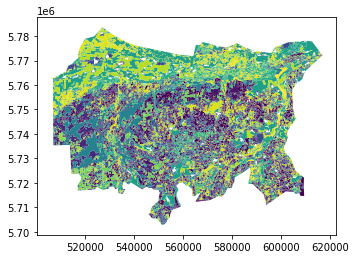

In [304]:
# Plot and check super classes
polesia_vector["superclass"] = polesia_vector.Leg.apply(map_eunis_to_superclass)
polesia_vector.plot("superclass")

In [231]:
len(polesia_vector.superclass.unique())

19

In [232]:
polesia_vector.superclass.unique()

array([ 8,  2,  3,  4,  9, 10, 11, 12, 19, 18, 13, 14,  1,  7,  6,  5, 15,
       16, 17])

### 4.2 Burn vector labels to raster

In [351]:
from src.unet.labels import empty_tif_like, burn_vector_to_raster

In [352]:
## Create empty tif template of same size as satellite dta to burn polesia data in
zeros_tif_like(img, GWS_DATA_DIR / "polesia_empty_10m_template.tif")

In [353]:
template = GWS_DATA_DIR / "polesia_empty_10m_template.tif"
burned_classes =  GWS_DATA_DIR / "polesia_burned_superclasses_all_touched_10m.tif"

burn_vector_to_raster(polesia_vector,
                      colname="superclass", 
                      template_path=template, 
                      save_path=burned_classes, 
                      fill=0,
                      all_touched=True,
                      dtype="uint8")

In [354]:
burned_vals = xr.open_rasterio(burned_classes, chunks={"band": 1, "x": 256, "y": 256})

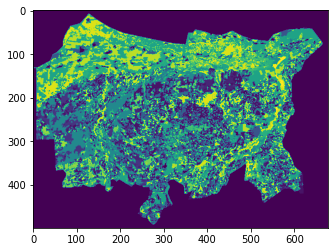

In [355]:
# Check burned raster data visually
polesia_raster_thumbnail = get_thumbnail(rasterio.open(burned_classes), height=500)
plt.imshow(polesia_raster_thumbnail);

# 5. Create pytorch dataloader

In [11]:
from src.unet.dataloader import SatelliteDataset, LabelledSatelliteDataset

#### Load labels

In [12]:
labels_path = GWS_DATA_DIR / "polesia_burned_superclasses_all_touched_10m.tif"
labels = SatelliteImage(labels_path)

#### Load satellite images

In [13]:
train_images = list(SENTINEL_POLESIA_DIR.glob("*[0-9].tif"))
unique_images = np.unique(list(map(lambda path: path.stem.split("-")[0], train_images)))
shard_paths = {img_name: list(SENTINEL_POLESIA_DIR.glob(img_name + "*[0-9].tif")) 
               for img_name in unique_images}

In [14]:
list(shard_paths.keys())

[]

### Load into dataset

In [15]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [16]:
rgb_bands = [2,1,0]

dataset = SatelliteDataset(SENTINEL_POLESIA_DIR / "predict", 
                           use_bands=rgb_bands, 
                           logger=logger)

labelled_dataset = LabelledSatelliteDataset(SENTINEL_POLESIA_DIR / "train", 
                                            labels_path=labels_path, 
                                            use_bands=rgb_bands, 
                                            logger=logger, 
                                            overlap_threshold=0.7,
                                            augmentations = {"rotation": True,
                                                             "flip": True})

In [17]:
dataset.ntiles

15972

In [18]:
labelled_dataset.ntiles 

3360

In [19]:
%%timeit
labelled_dataset[0]

75.3 ms ± 7.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
index = 3
image_index = labelled_dataset._get_image_index(index)
tile_bounds = labelled_dataset._get_tile_bounds(index)

image = labelled_dataset._get_tile_from_bounds(image_index, *tile_bounds, mode="image")
label = labelled_dataset._get_tile_label(*tile_bounds)

In [22]:
plt.imshow(labelled_dataset._augment(Image.fromarray((label*255).astype('uint8')), 6))

AttributeError: 'Tensor' object has no attribute 'astype'

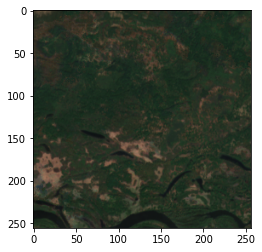

In [318]:
plt.imshow(labelled_dataset._augment(Image.fromarray((image*255).astype('uint8')), 6))

In [223]:
%%timeit
labelled_dataset.labels_one_hot[row_min:row_max, col_min:col_max]

3.03 µs ± 19.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [268]:
def inspect_tile(index, dataset=labelled_dataset):
    
    fig, ax = plt.subplots(1)
    
    dataset.use_one_hot = False
    image_index = dataset._get_image_index(index)
    tile_bounds = dataset._get_tile_bounds(index)
    print(image_index)
    print(tile_bounds)
    
    image = dataset._get_tile_from_bounds(image_index, *tile_bounds, mode="image")
    label = dataset._get_tile_label(*tile_bounds)
    dataset.use_one_hot = True
    
    plt.imshow(image)
    #plt.show()
    plt.imshow(label, 
               alpha=0.2)

    plt.show()

0
(512, 1536, 768, 1792)


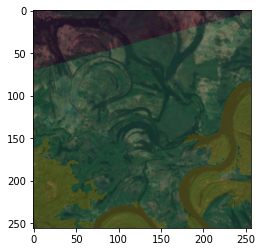

In [269]:
inspect_tile(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
(6144, 10240, 6400, 10496)


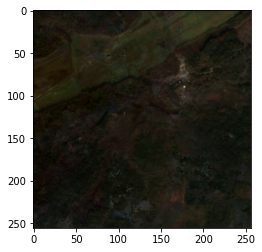

In [176]:
index = 4000
plt.imshow(reshape_as_image(dataset[index]) / 3000)
print(dataset._get_image_index(index))
print(dataset._get_tile_bounds(index))

In [181]:
labelled_dataset.labels_one_hot

tensor([[[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1,

In [67]:
label_arr = labels.combined_image.data.compute()
unique_labels = np.unique(label_arr)

In [70]:
import torch
import torch.nn.functional

In [77]:
label_tensor = torch.from_numpy(label_arr.squeeze())

In [84]:
label_tensor.long()

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [81]:
torch.arange(0, 6).view(3,2).shape

torch.Size([3, 2])

In [83]:
torch.nn.functional.one_hot(torch.arange(0, 6).view(3,2), num_classes=6)

tensor([[[1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1]]])

In [93]:
label_tensor = torch.from_numpy(reshape_as_image(label_arr).squeeze()).long()

In [98]:
label_onehot_tensor = torch.nn.functional.one_hot(label_tensor, num_classes=len(unique_labels))

In [57]:
img = SatelliteImage(shard_paths['S2_pol_2017_AMJ'])
rgb_vals = [2,1,0]

In [58]:
img.combined_image

,Array,Chunk
Bytes,7.57 GB,524.29 kB
Shape,"(10, 8351, 11324)","(1, 256, 256)"
Count,44554 Tasks,14850 Chunks
Type,float64,numpy.ndarray


#### Briefly inspect a sample tile and its labels to check if they correspond

In [16]:
area_to_query = (slice(256*5,256*6), slice(256*5, 256*6))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


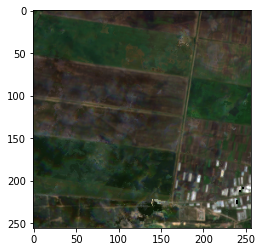

In [27]:
plt.imshow(reshape_as_image(img[(rgb_vals, *area_to_query)].compute()) / 3000)

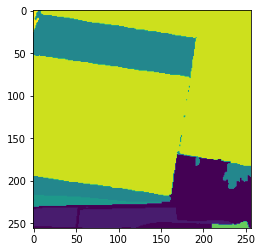

In [157]:
plt.imshow(labels[((0, *area_to_query))].compute())

In [28]:
np.sum(dataset.tile_label_overlaps > 0.7)

840

Text(0.5, 1.0, 'Tile-Label overlap fraction')

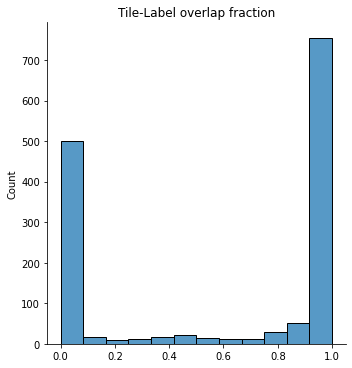

In [29]:
sns.displot(dataset.tile_label_overlaps)
plt.title("Tile-Label overlap fraction")

In [32]:
dataset.tile_center_coords[dataset.tile_label_overlaps > 0.7]

array([[ 384, 2176],
       [ 640, 1664],
       [ 640, 1920],
       ...,
       [7808, 4224],
       [7808, 4480],
       [7808, 4736]])